In [1]:
%cd ..
%ls 

from ch_est_net.preloading import *
from ch_est_net.utils import *

from torch.fft import fft, ifft, fftshift, ifftshift
from ch_est_net import activation

%load_ext autoreload
%autoreload 2

import torch
print(torch.__version__)



/home/alex/GitHub/ML_for_channel_estimation
ch_est_net/        lista_beam_net.pt  output.svg        torchvix-sample
config_beams.yaml  model_image        __pycache__/      torchvix-sample.png
config.yaml        model_image.png    README.md         zero_150.pt
data.h5            Notebooks/         requirements.txt  zero.pt
DMRS_signal/       one.pt             results/
1.10.1


In [2]:
cfg, dataL, dataS, device, deviceType, dtype, file, ml_default, onePilotFolder, path ,preload, print_function, scen0, Scenario = crazy_preloader()

Using CPU

Preload data: OK


In [3]:
def get_batch(snr_range, ind_range, seed):
    '''
    For files ind_range add noise with snr_range and stack all realizations to single array
    --------------------------------------------------------------------------
    RETURNS:
    pilot_batch -> [Realizations ; Antennas ; Subc ; Re/Im ]
    data_batch  -> [Realizations ; Antennas ; Subc ; 12? ; Re/Im]
    pilot_batch -> [Realizations]
    --------------------------------------------------------------------------
    Realizations = len(snr_range)*len(ind_range) 
    '''

    pilot_batch = torch.tensor(())
    pilot_noisy_batch = torch.tensor(())
    data_batch = torch.tensor(())
    noise_P_batch = torch.tensor(())

    for snr in snr_range:
        for ind in ind_range:
            h_pilot, h_data = data_load(scen0, dtype = dtype, onePilotFolder = onePilotFolder,dataL=dataL, ind = ind) 
                                                  # load data
            h_pilot_noisy, _ = add_noise(h_pilot, SNR = snr,scen=scen0, dtype=dtype, seed = seed)                             # add noise to pilots
            h_data_noisy, data_noise_power = add_noise_data(h_data, SNR = snr, dtype = dtype, seed = seed)     # add noise to data

            h_pilot = h_pilot.mean(dim = 2).unsqueeze(dim = 0)                                  # mean over pilots dim and add aditional dim
            h_pilot_noisy = h_pilot_noisy.mean(dim = 2).unsqueeze(dim = 0)

            h_data_noisy = h_data_noisy.unsqueeze(dim = 0)                                      # add additional dim for
            data_noise_power = data_noise_power.unsqueeze(dim =0)

            pilot_batch = torch.cat((pilot_batch, h_pilot), dim = 0)

            pilot_noisy_batch = torch.cat((pilot_noisy_batch, h_pilot_noisy), dim = 0)
            data_batch = torch.cat((data_batch, h_data_noisy), dim = 0)
            noise_P_batch = torch.cat((noise_P_batch, data_noise_power), dim = 0)

    return pilot_batch, pilot_noisy_batch, data_batch, noise_P_batch



snr_range = [-12, -10, -8 ,-5 , -2, 5, 10, 30]
x_batch, u_batch, _, _ = get_batch(snr_range = snr_range,
                                            ind_range = range(1,140,5),
                                            seed = 312)



x_test, u_test, _, _ = get_batch(snr_range = [-12, -10, -8 ,-5 , -2],
                                              ind_range = range(2, 141, 5),
                                              seed = 2)


x_batch = x_batch[:,:,:,0] + 1j*x_batch[:,:,:,1]
u_batch = u_batch[:,:,:,0] + 1j*u_batch[:,:,:,1]

x_test = x_test[:,:,:,0] + 1j*x_test[:,:,:,1]
u_test = u_test[:,:,:,0] + 1j*u_test[:,:,:,1]


In [4]:
def beam_time_transform(x):
    if len(x.shape)==2:
        x = torch.unsqueeze(x, dim = 0)

    x_a_t = ifft(x , n = 512, dim = 2, norm = 'ortho')
    x_a_t = torch.roll(x_a_t, shifts = 206, dims= 2)
    x_b_t = fft(x_a_t, n = 512, dim = 1, norm = 'ortho')

    return torch.squeeze(x_b_t, dim = 0)    

def ant_freq_transform(x):
    if len(x.shape)==2:
        x = torch.unsqueeze(x, dim = 0)
    
    x = torch.roll(x, shifts= -206, dims =2)
    x_a_t = ifft(x, n = 512, dim = 1, norm = 'ortho')
    x_a_t = x_a_t[:,:64,:]
    x_a_f = fft(x_a_t, n = 512, dim = 2, norm ='ortho')
    x_a_f = x_a_f[:,:,:48]
    
    return torch.squeeze(x_a_f, dim = 0)

from torch.nn.functional import mse_loss
def MSE(x_real, x_hat):
    '''Mean squared error generalized for complex values'''

    assert x_real.shape == x_hat.shape, 'Sizes of both values must be the same, but got {0} and {1} instead'.format(x_real.shape, x_hat.shape)
    
    if torch.is_complex(x_real):
        mse = torch.sum(torch.abs(x_real-x_hat)**2)/torch.numel(x_real)

    else:
        mse = mse_loss(x_real, x_hat)

    return mse

x_batch_spec = beam_time_transform(x_batch)
u_batch_spec = beam_time_transform(u_batch)
x_test_spec = beam_time_transform(x_test)
u_test_spec = beam_time_transform(u_test)

In [5]:

def mean_scaller(in_data):
    out_data = torch.zeros_like(in_data)
    for idx in range(in_data.shape[0]):
        out_data[idx] = in_data[idx] - torch.mean(in_data[idx])
        out_data[idx] = in_data[idx] / torch.std(in_data[idx], unbiased = False)
    return out_data 



def re_im_mean_scaller(in_data):
    out_data_re = torch.zeros_like(in_data)
    out_data_im = torch.zeros_like(in_data)
    
    for idx in range(in_data.shape[0]):
        out_data_re[idx] = in_data[idx].real - torch.mean(in_data[idx].real)
        out_data_re[idx] = in_data[idx].real / torch.std(in_data[idx].real, unbiased = False)
        
        out_data_im[idx] = in_data[idx].imag - torch.mean(in_data[idx].imag)
        out_data_im[idx] = in_data[idx].imag / torch.std(in_data[idx].imag, unbiased = False)


    return out_data_re + 1j*out_data_im 



def noise_mean_scaller(in_data):
    out_data = torch.zeros_like(in_data)
    in_data = torch.roll(in_data, shifts = 150, dims = 1)
    noise_data = in_data[:,10:150,:]

    for idx in range(in_data.shape[0]):
        out_data[idx] = in_data[idx] - torch.mean(noise_data[idx])
        out_data[idx] = in_data[idx] / torch.std(noise_data[idx], unbiased = False)
    return out_data 




In [6]:
# shape [SNR, file, beams, time]
x_batch_spec_ = torch.reshape(x_batch_spec, (len(snr_range),-1,512,512))
u_batch_spec_ = torch.reshape(u_batch_spec, (len(snr_range),-1,512,512))
x_batch_spec_scaled = torch.reshape(mean_scaller(x_batch_spec), (len(snr_range),-1,512,512))
u_batch_spec_scaled = torch.reshape(mean_scaller(u_batch_spec), (len(snr_range),-1,512,512))
x_batch_spec_noise_scaled = torch.reshape(noise_mean_scaller(x_batch_spec), (len(snr_range),-1,512,512))
u_batch_spec_noise_scaled = torch.reshape(noise_mean_scaller(u_batch_spec), (len(snr_range),-1,512,512))
x_batch_spec_re_im = torch.reshape(re_im_mean_scaller(x_batch_spec), (len(snr_range),-1,512,512))
u_batch_spec_re_im = torch.reshape(re_im_mean_scaller(u_batch_spec), (len(snr_range),-1,512,512))

In [7]:
def concat_images(in_data):
    out_data = torch.tensor(())
    for idx_snr in range(in_data.shape[0]):
        row_data = torch.tensor(())
        for idx_file in range(in_data.shape[1]):
            row_data = torch.concat((row_data, in_data[idx_snr, idx_file,:,:]),dim = 1)
        out_data = torch.concat((out_data, row_data), dim = 0)

    return out_data


In [8]:
cat_u_batch = concat_images(u_batch_spec_)
cat_u_batch_scaled = concat_images(u_batch_spec_scaled)
cat_u_batch_noise_scaled = concat_images(u_batch_spec_noise_scaled)
cat_u_batch_prev_scaled = concat_images(u_batch_spec_re_im)

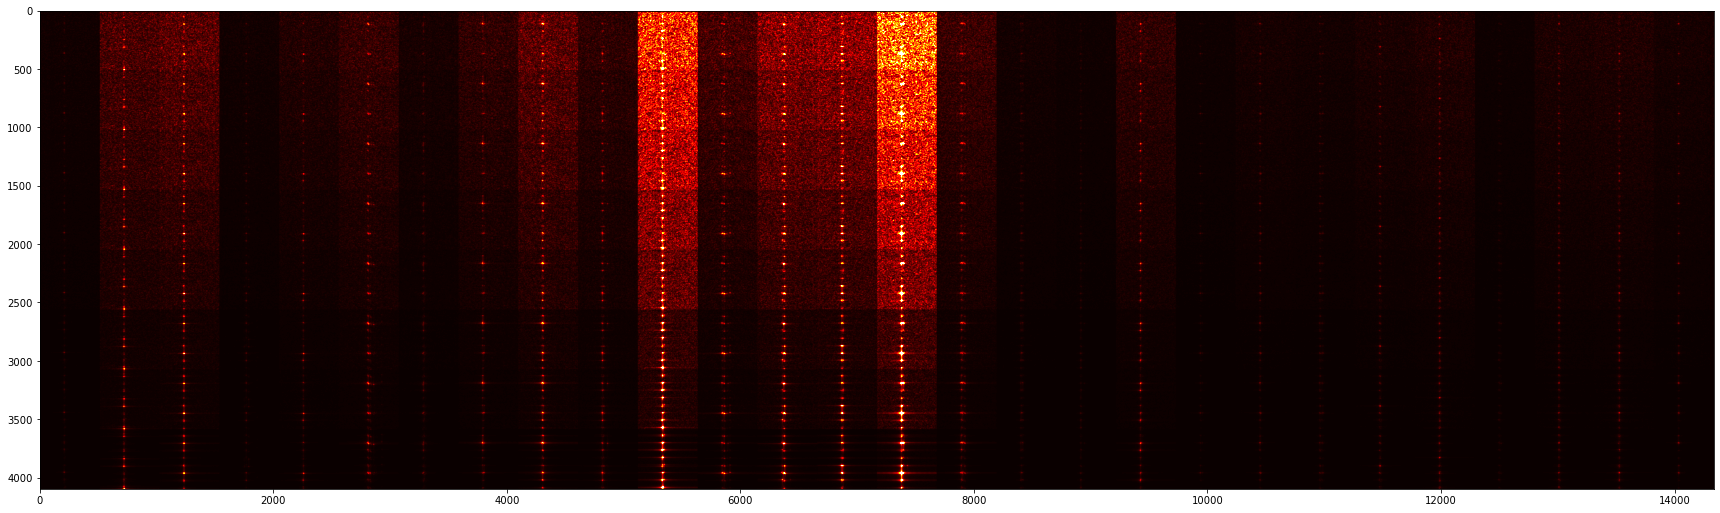

In [9]:
plt.figure(figsize=(30,20))
plt.imshow(abs(cat_u_batch[:, :]), cmap= 'hot')
plt.clim(0,2)

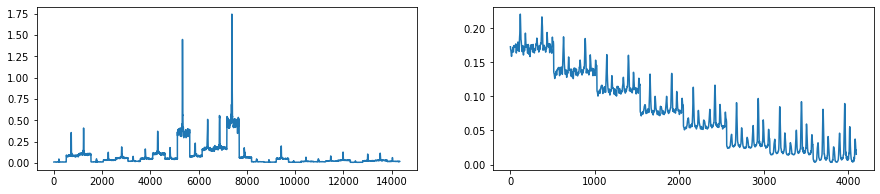

In [18]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(torch.mean(abs(cat_u_batch), dim = 0))
plt.subplot(1,2,2)
plt.plot(torch.mean(abs(cat_u_batch), dim = 1))

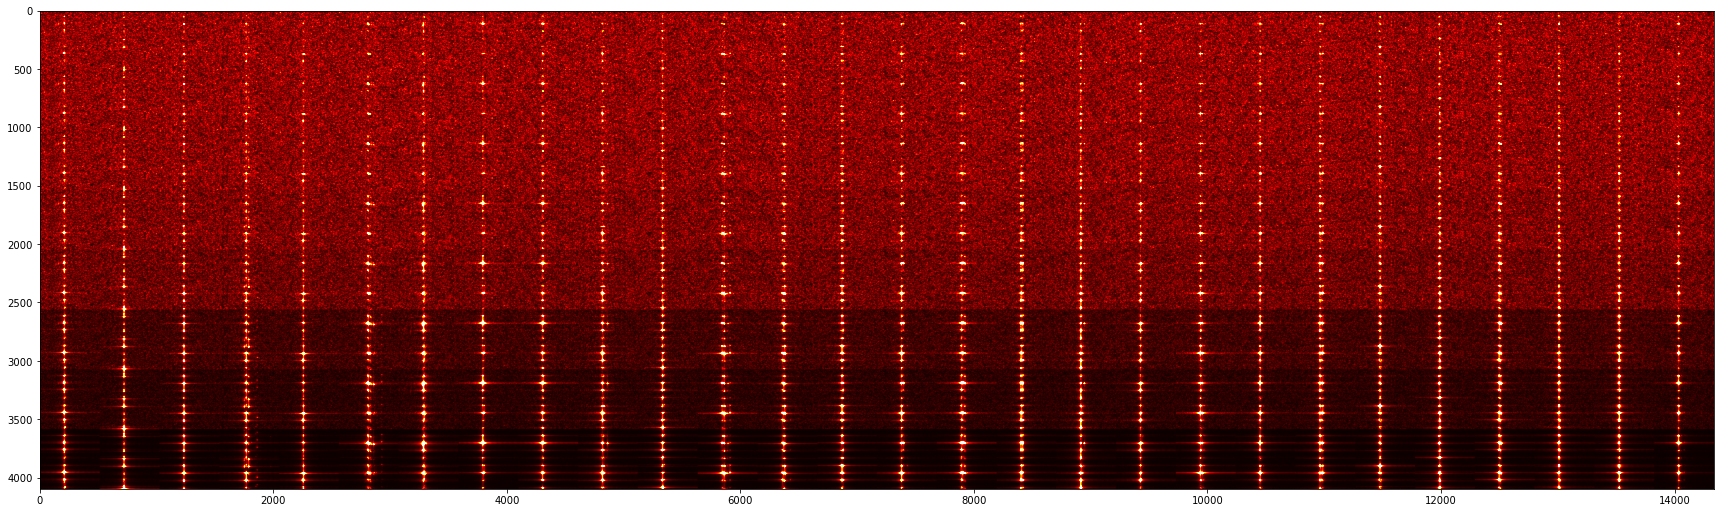

In [19]:
plt.figure(figsize=(30,20))
plt.imshow(abs(cat_u_batch_scaled[:, :]), cmap= 'hot')
plt.clim(0,4)


In [20]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(torch.mean(abs(cat_u_batch_scaled), dim = 0))
plt.subplot(1,2,2)
plt.plot(torch.mean(abs(cat_u_batch_scaled), dim = 1))

In [22]:
plt.figure(figsize=(30,20))
plt.imshow(abs(cat_u_batch_noise_scaled[:, :]), cmap= 'hot')
plt.clim(0,4)
#plt.colorbar()

In [23]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(torch.mean(abs(cat_u_batch_noise_scaled), dim = 0))
plt.subplot(1,2,2)
plt.plot(torch.mean(abs(cat_u_batch_noise_scaled), dim = 1))

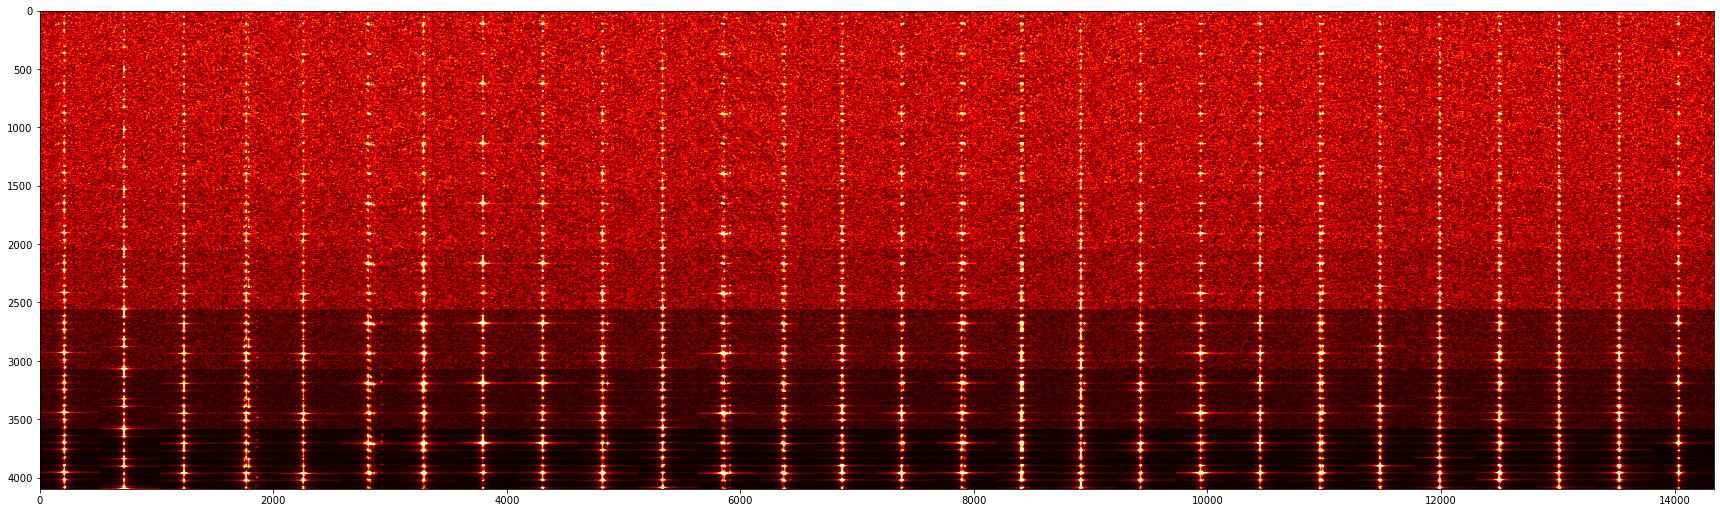

In [24]:
plt.figure(figsize=(30,20))
plt.imshow(abs(cat_u_batch_prev_scaled[:, :]), cmap= 'hot')
plt.clim(0,4)
#plt.colorbar()

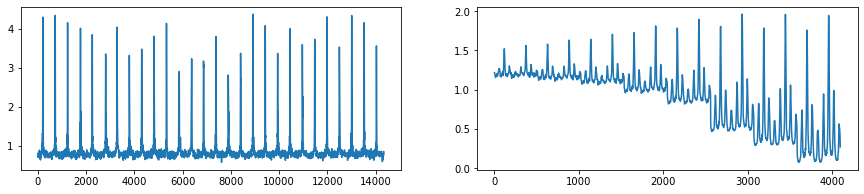

In [25]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(torch.mean(abs(cat_u_batch_prev_scaled), dim = 0))
plt.subplot(1,2,2)
plt.plot(torch.mean(abs(cat_u_batch_prev_scaled), dim = 1))

In [27]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(torch.mean(abs(cat_u_batch_prev_scaled), dim = 0))
plt.plot(torch.mean(abs(cat_u_batch_scaled), dim = 0))
plt.subplot(1,2,2)
plt.plot(torch.mean(abs(cat_u_batch_prev_scaled), dim = 1))
plt.plot(torch.mean(abs(cat_u_batch_scaled), dim = 1))
